### Instalação
- conda install -c conda-forge fbprophet

### Séries de cotações
- https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/aplicacao#!/recursos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime as dt

In [2]:
pd.plotting.register_matplotlib_converters()
plt.rcParams['figure.figsize']=(14,8)

In [3]:
# importando o csv das cotações de venda de moeda estrangeira
moeda = "Dolar"
ano_inicial = 2010
dados_csv = pd.read_csv("datasets/cotacao_%s.csv"%(moeda.split()[0].lower()))
dados_csv.tail()

,cotacaoVenda,dataHoraCotacao,tipoBoletim
17846,"5,2643",2020-09-18 10:04:17.311,Abertura
17847,"5,2843",2020-09-18 11:08:17.654,Intermediário
17848,"5,2944",2020-09-18 12:05:18.839,Intermediário
17849,"5,3124",2020-09-18 13:07:46.208,Intermediário
17850,"5,2889",2020-09-18 13:07:46.211,Fechamento


In [4]:
# filtra cotacoes de Fechamento
dados_brutos = dados_csv.loc[dados_csv.tipoBoletim == "Fechamento"]
dados_brutos = dados_brutos.reset_index().drop(["tipoBoletim", "index"], axis=1)
dados_brutos.tail()

,cotacaoVenda,dataHoraCotacao
2687,"5,2984",2020-09-14 13:11:26.344
2688,"5,2728",2020-09-15 13:05:23.52
2689,"5,2532",2020-09-16 13:07:28.885
2690,"5,2593",2020-09-17 13:08:53.951
2691,"5,2889",2020-09-18 13:07:46.211


In [5]:
# Renomear e tratar as colunas para os formatos do fbprophet
dados = dados_brutos.copy()
dados.columns = ["y", "ds"]

# usando apenas o dia e ignorando o horário
dados.ds = pd.to_datetime(dados.ds.str[:10])
dados = dados.set_index("ds")

# convertendo formato da parte decimal
dados.y = pd.to_numeric(dados.y.str.replace(",", "."))

# filtrando períodos
#dados = dados[:"2015-03-01"]
dados.tail()

,y
ds,
2020-09-14,5.2984
2020-09-15,5.2728
2020-09-16,5.2532
2020-09-17,5.2593
2020-09-18,5.2889


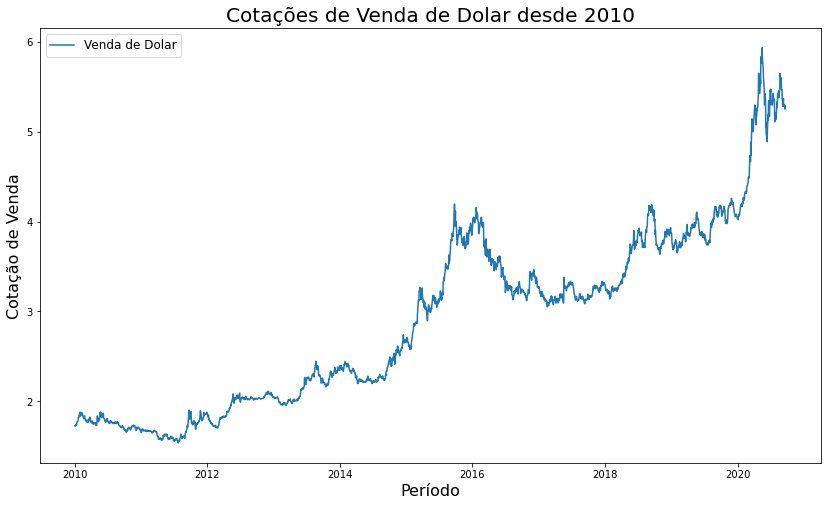

In [6]:
plt.plot(dados, label="Venda de %s"%moeda)
plt.title("Cotações de Venda de %s desde %d"%(moeda, ano_inicial), fontsize=20)
plt.xlabel("Período", fontsize=16)
plt.ylabel("Cotação de Venda", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [7]:
# criando e rodando o modelo fbprophet
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(dados.reset_index())

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [8]:
# quantos dias serão previstos
futuro = model.make_future_dataframe(periods=180)
futuro.max()

ds   2021-03-17
dtype: datetime64[ns]

In [9]:
# fazendo as predições
previsao = model.predict(futuro)
previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2867,2021-03-13,5.465746,5.217136,5.724045
2868,2021-03-14,5.471059,5.214237,5.742041
2869,2021-03-15,5.491537,5.234430,5.764308
2870,2021-03-16,5.496031,5.239131,5.749659
2871,2021-03-17,5.503873,5.243882,5.753218


In [10]:
previsao.reset_index(inplace=True)
previsao.ds = pd.to_datetime(previsao.ds)
previsao.set_index('ds', inplace=True)

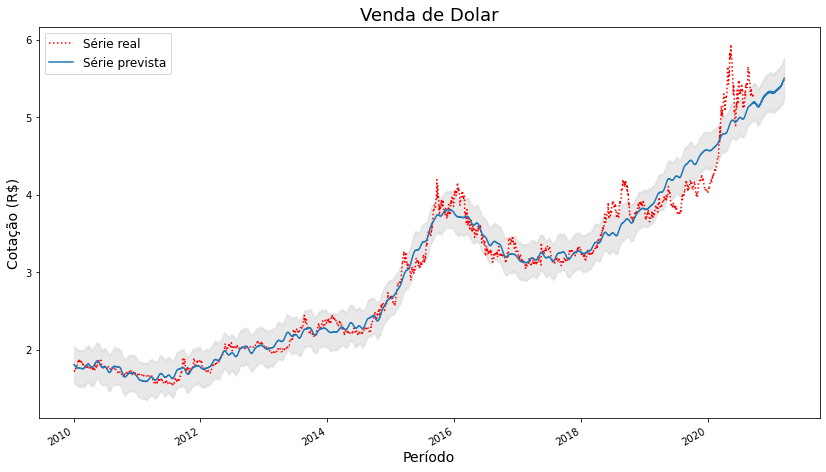

In [11]:
# Customizando o plot do fbprophet
fig = dados.y.plot(color="red", alpha=1, linestyle=":")
previsao.yhat.plot()
fig.fill_between(previsao.index, previsao.yhat_upper, previsao.yhat_lower, alpha=0.5, color="lightgray")
fig.set_title("Venda de %s"%moeda, fontsize=18)
fig.set_ylabel("Cotação (R$)", fontsize=14)
fig.set_xlabel("Período", fontsize=14)
fig.grid(False)

L=fig.legend(fontsize=12)
L.get_texts()[0].set_text("Série real")
L.get_texts()[1].set_text("Série prevista")
plt.show()

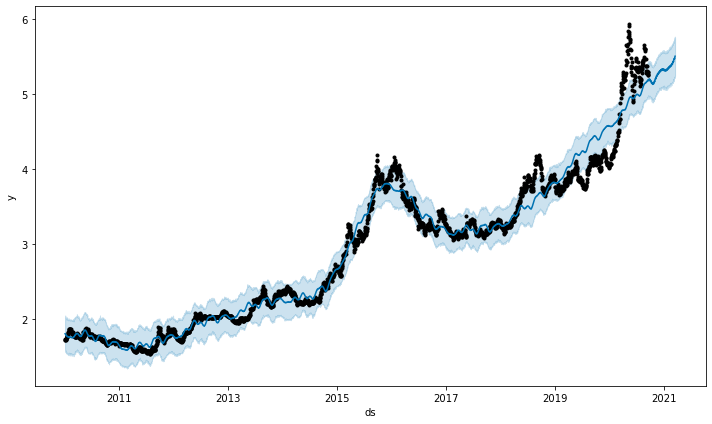

In [12]:
# Plot padrão do prophet
model.plot(previsao.reset_index())
plt.grid(False)
plt.show()

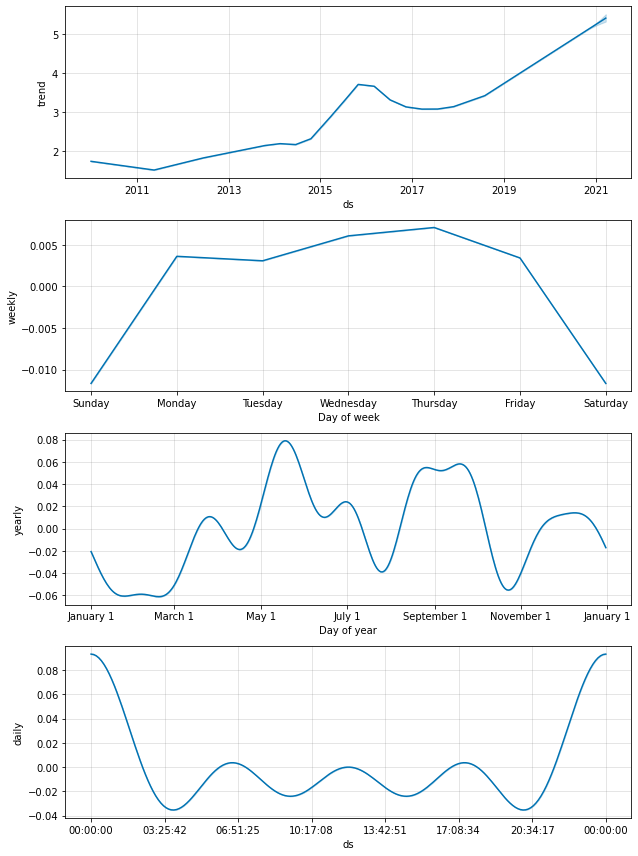

In [13]:
# Extras, não usarei no TCC
model.plot_components(previsao.reset_index())
plt.show()